# Imports and constants

In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import visualizer.Viewer as vw
from Metrics import compute_metrics, make_metric_plots
from models.time_series.anomaly.deep_learning.GRUAutoencoder import GRUAutoencoder
from reader.NABTimeSeriesReader import NABTimeSeriesReader

# DATASET 1: ambient_temperature_system_failure
# DATASET 2: nyc_taxi
VALIDATION_DIM = 0.19
DATASET_PATH = "data/dataset/"
DATASET = "nyc_taxi.csv"
PURE_DATA_KEY = "realKnownCause/nyc_taxi.csv"
GROUND_WINDOWS_PATH = "data/dataset/combined_windows.json"
# The number of normal samples that must lie between a normal slice and an anomaly
SAFETY_DIM = 50
MINIMUM_SLICE = 100
ALL_METRICS = True
LOAD_MODEL = False
CHECK_OVERFITTING = False
AUTOENCODER_WINDOW = 32


def preprocess(X) -> np.ndarray:
    return StandardScaler().fit_transform(X)

# Set seed for reproducibility

In [2]:
np.random.seed(57)
tf.random.set_seed(57)

# Load training and testing data

In [3]:
reader = NABTimeSeriesReader(DATASET_PATH)
all_df = reader.read(DATASET_PATH + DATASET).get_dataframe()
training, test = reader.train_test_split(train_perc=0.37).get_train_test_dataframes()

# Data used to train
data = preprocess(np.array(training["value"]).reshape((training["value"].shape[0], 1)))
data_labels = training["target"]

# Data used to test
data_test = preprocess(np.array(test["value"]).reshape((test["value"].shape[0], 1)))
data_test_labels = test["target"]

# Eliminate exceeding points
if data_test.shape[0] % AUTOENCODER_WINDOW != 0:
    remainder_points = data_test.shape[0] % AUTOENCODER_WINDOW
    
    np_data = np.array(data)
    np_data_test = np.array(data_test)
    np_data_labels = np.array(data_labels)
    np_data_test_labels = np.array(data_test_labels)
    data = np.concatenate((np_data, np_data_test[0:remainder_points]))
    data_labels = np.concatenate((np_data_labels, np_data_test_labels[0:remainder_points]))
    data_test = data_test[remainder_points:]
    data_test_labels = data_test_labels[remainder_points:]
    
    np_train = np.concatenate((np.array(training), np.array(test[:remainder_points])))
    training = pd.DataFrame(np_train, columns=training.columns)
    
    np_test = np.array(test[remainder_points:])
    test = pd.DataFrame(np_test, columns=test.columns)

# Data used to evaluate
dataframe = test.copy()
dataframe["value"] = data_test

if CHECK_OVERFITTING:
    data_test = preprocess(np.array(training["value"]).reshape(training["value"].shape[0], 1))
    data_test_labels = training["target"]
    dataframe = training.copy()
    dataframe["value"] = data_test

# Set slices on which to train and validate

In each case we use a self-supervised approach. The models are built to be able to correctly reproduce normal samples of the data. Therefore, from the training dataset, we want to exclude all possible anomalies and their neighbouring points not to learn anomalies patterns. In such a way, we aim the model to produce big mispredictions for those points that are anomalies. Given these statements, from training and validation set we extract slices without anomalies.

In [4]:
# Create the slices of the trainig data
change_idx = np.where(np.array(data_labels[:-1]) != np.array(data_labels[1:]))
change_idx = np.array(change_idx) + 1
change_idx = change_idx.reshape(change_idx.shape[1])
change_idx = np.concatenate((np.array([0]), change_idx))
normal_slices = []
anomaly_slices = []
for i in range(len(change_idx)):
    start = change_idx[i]
    if i < len(change_idx) -1:
        stop = change_idx[i+1]
    else:
        stop = data.shape[0]
    
    if data_labels[change_idx[i]] == 1:
        anomaly_slices.append(slice(start, stop))
    else:
        normal_slices.append(slice(start, stop))

print("The slices before safety check: %s" % normal_slices)

for i in range(len(normal_slices)):
    start_first = False
    end_last = False
    if normal_slices[i].start == 0:
        start_first = True
    if normal_slices[i].stop == data.shape[0]:
        end_last = True
    
    if not start_first and not end_last:
        normal_slices[i] = slice(normal_slices[i].start + SAFETY_DIM,
                                 normal_slices[i].stop - SAFETY_DIM,
                                 normal_slices[i].step)
    elif not start_first and end_last:
        normal_slices[i] = slice(normal_slices[i].start + SAFETY_DIM,
                                 normal_slices[i].stop,
                                 normal_slices[i].step)
    elif start_first and not end_last:
        normal_slices[i] = slice(normal_slices[i].start,
                                 normal_slices[i].stop - SAFETY_DIM,
                                 normal_slices[i].step)

print("The slices after safety check: %s" % normal_slices)

The slices before safety check: [slice(0, 3824, None)]
The slices after safety check: [slice(0, 3824, None)]


# Computation of training and validation slices

Given the slices of normal points on which we will train and validate the model, we need to compute the slices characterizing the training and the validation samples of the dataset. To do so, we will need to iterate over the normal slices to compute the number of points in it. Then, we compute the number of points required for the validation set and from this number we will compute the validation slices. However, we risk to compute slices of only 1 sample in some extreme cases. Therefore, we will control that each slice is at least of `MINIMUM_SLICE` samples.

In [5]:
# Gets the step (equal for all slices)
step = normal_slices[0].step if normal_slices[0].step is not None else 1
ok_normal_slices = []
tot_samples = 0
for i in range(len(normal_slices)):
    samples = int((normal_slices[i].stop - normal_slices[i].start) / step)
    if samples > MINIMUM_SLICE:
        tot_samples += samples
        ok_normal_slices.append(normal_slices[i])
        
valid_points = tot_samples * VALIDATION_DIM
training_slices = []
validation_slices = []
tot_valid = 0
for i in reversed(range(len(ok_normal_slices))):
    if tot_valid >= valid_points:
        training_slices.append(ok_normal_slices[i])
    else:
        samples = int((ok_normal_slices[i].stop - ok_normal_slices[i].start) / step)
        needed_points = valid_points - tot_valid

        if samples < needed_points:
            validation_slices.append(ok_normal_slices[i])
        else:
            train_stop = int(ok_normal_slices[i].stop - needed_points * step)
            slice_train = slice(ok_normal_slices[i].start,
                                train_stop,
                                ok_normal_slices[i].step)
            slice_valid = slice(train_stop,
                                ok_normal_slices[i].stop,
                                ok_normal_slices[i].step)
            
            # If points are enough, they are added to lists
            if (slice_train.stop - slice_train.start) / step >= MINIMUM_SLICE:
                training_slices.append(slice_train)
            if (slice_valid.stop - slice_valid.start) / step >= MINIMUM_SLICE:
                validation_slices.append(slice_valid)
                
            # Since in this else we enter only at the last slice, set up to exit in case minimum
            # slice is not reached
            tot_valid = valid_points + 1
            
training_slices.reverse()
validation_slices.reverse()

print("The training slices are: %s" % training_slices)
print("The validation slices are: %s" % validation_slices)

The training slices are: [slice(0, 3097, None)]
The validation slices are: [slice(3097, 3824, None)]


# Load or fit the model

In [6]:
model = GRUAutoencoder(window=AUTOENCODER_WINDOW,
                       max_epochs=500,
                       batch_size=32,
                       extend_not_multiple=True,
                       filename="nyc_ae_gru")
if LOAD_MODEL:
    model.load_model("data/nn_models/nyc_ae_gru")
else:
    model.fit(data, training_slices, validation_slices, data_labels)

[2022/05/17 18:33:14] WARNING: Data will be modified to match the window size, note that the input must be a multiple of the window size for autoencoders. This is just a comfort utility. You can ignore this warning if no other warnings regarding the training set pop up.
[2022/05/17 18:33:14] WARNING: On 1th training slice, 25 points have been lost
[2022/05/17 18:33:14] WARNING: On 1th validation slice, 23 points have been lost
Model: "gru_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 1)]           0         
                                                                 
 encoder_gru_1 (GRU)         (None, 32, 128)           50304     
                                                                 
 encoder_gru_2 (GRU)         (None, 64)                37248     
                                                                 
 repeat_vector (

Epoch 37/500
76/76 [==============================] - 4s 59ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - lr: 0.0010
Epoch 38/500
76/76 [==============================] - 4s 56ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - lr: 0.0010
Epoch 39/500
76/76 [==============================] - 4s 56ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - lr: 0.0010
Epoch 40/500
76/76 [==============================] - 4s 56ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - lr: 0.0010
Epoch 41/500
76/76 [==============================] - 4s 55ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - lr: 0.0010
Epoch 42/500
76/76 [==============================] - 4s 56ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_los

76/76 [==============================] - 5s 67ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - lr: 0.0010
Epoch 84/500
76/76 [==============================] - 5s 64ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - lr: 0.0010
Epoch 85/500
76/76 [==============================] - 5s 62ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - lr: 0.0010
Epoch 86/500
76/76 [==============================] - 5s 63ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - lr: 0.0010
Epoch 87/500
76/76 [==============================] - 5s 64ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - lr: 0.0010
Epoch 88/500
76/76 [==============================] - 5s 63ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0205 - v

76/76 [==============================] - 5s 62ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - lr: 0.0010
Epoch 130/500
76/76 [==============================] - 5s 62ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - lr: 0.0010
Epoch 131/500
76/76 [==============================] - 5s 62ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - lr: 0.0010
Epoch 132/500
76/76 [==============================] - 5s 61ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - lr: 0.0010
Epoch 133/500
76/76 [==============================] - 5s 60ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - lr: 0.0010
Epoch 134/500
76/76 [==============================] - 5s 60ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.011

Epoch 175/500
76/76 [==============================] - 4s 55ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - lr: 1.0000e-04
Epoch 176/500
76/76 [==============================] - 4s 54ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - lr: 1.0000e-04
Epoch 177/500
76/76 [==============================] - 4s 53ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - lr: 1.0000e-04
Epoch 178/500
76/76 [==============================] - 4s 54ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - lr: 1.0000e-05
Epoch 179/500
76/76 [==============================] - 4s 54ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - lr: 1.0000e-05
Epoch 180/500
76/76 [==============================] - 4s 54ms/step - loss: 0.0035 - mean_squar

# Compute labels and scores

In [7]:
true_labels = np.asarray(data_test_labels, dtype=np.intc)
labels = model.predict(data, data_test)
scores = model.anomaly_score(data, data_test)
perc = np.sum(labels) / labels.shape[0]

# Evaluation metrics for anomaly detection

In [8]:
compute_metrics(true_labels, scores, labels, compute_roc_auc=not CHECK_OVERFITTING, only_roc_auc=False)

ACCURACY SCORE:  0.9833743842364532
PRECISION SCORE:  0.018691588785046728
RECALL SCORE:  0.4
F1 SCORE:  0.03571428571428571
AVERAGE PRECISION SCORE:  0.06303001840413927
PRECISION-RECALL AUC SCORE:  0.03539923718033598
AUROC SCORE:  0.9114158065013095


# Confusion matrix

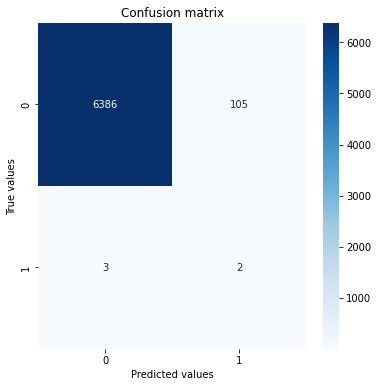

In [9]:
confusion_matrix = metrics.confusion_matrix(true_labels, labels)
vw.plot_confusion_matrix(confusion_matrix)

# ROC curve

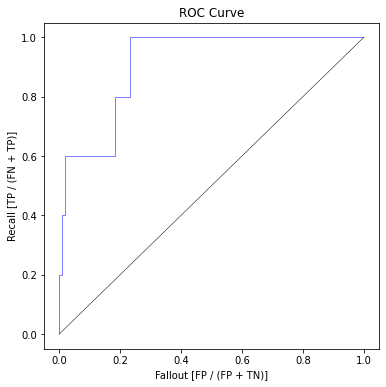

In [10]:
vw.plot_roc_curve(true_labels, scores)

# Precision-recall curve

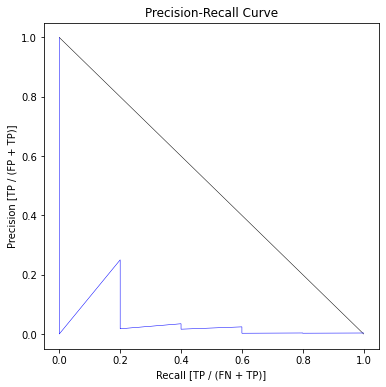

In [11]:
vw.plot_precision_recall_curve(true_labels, scores)

# Assigned labels

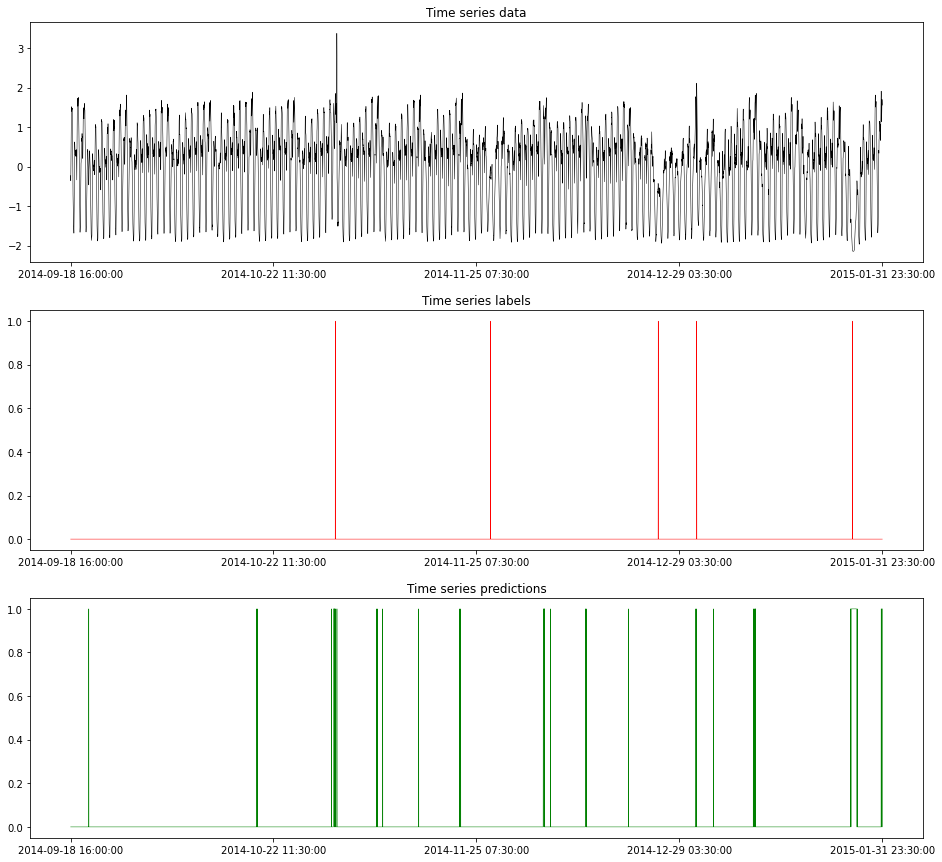

In [12]:
vw.plot_univariate_time_series_predictions(dataframe, labels)

# Assigned scores

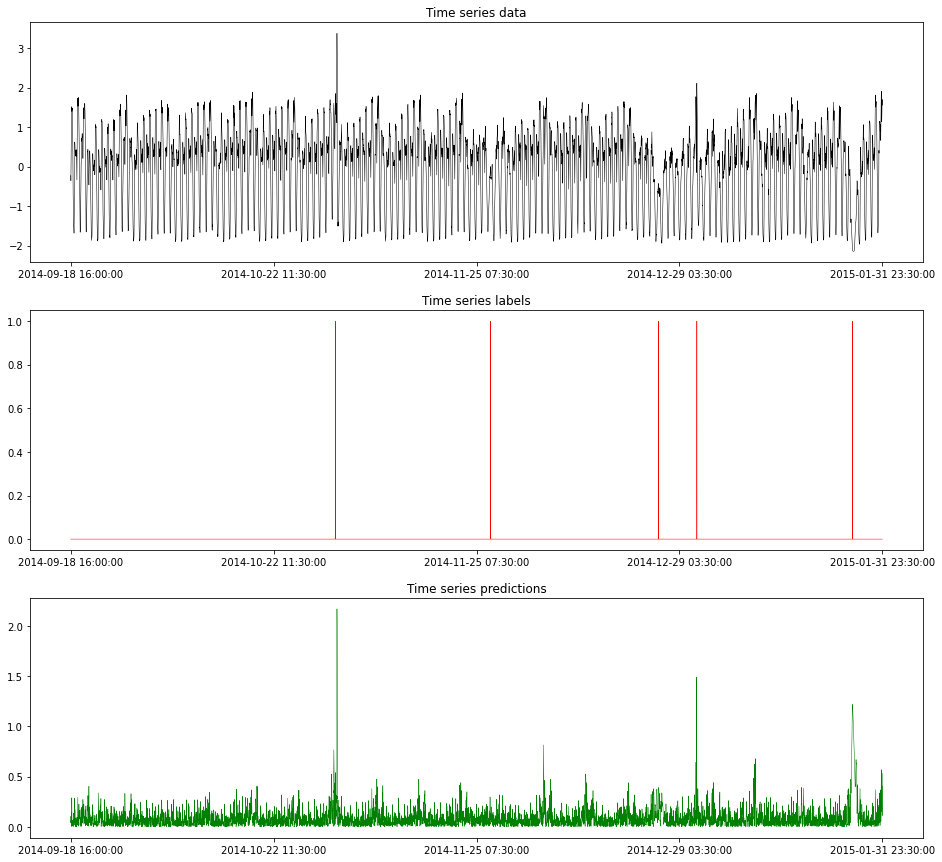

In [13]:
vw.plot_univariate_time_series_predictions(dataframe, scores)

# Data and predictions

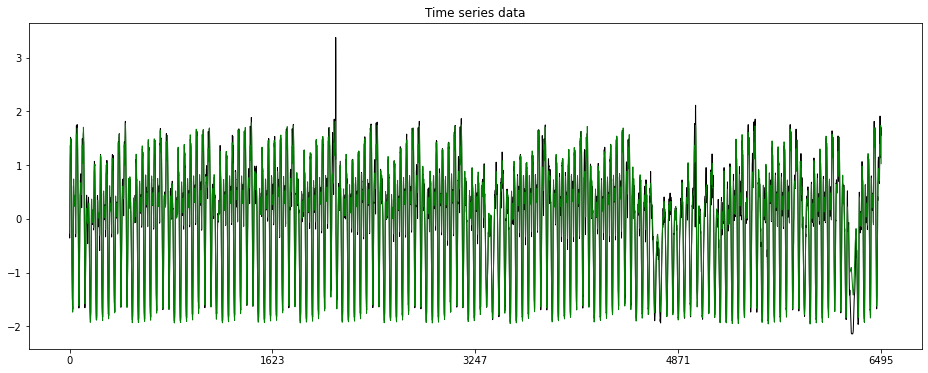

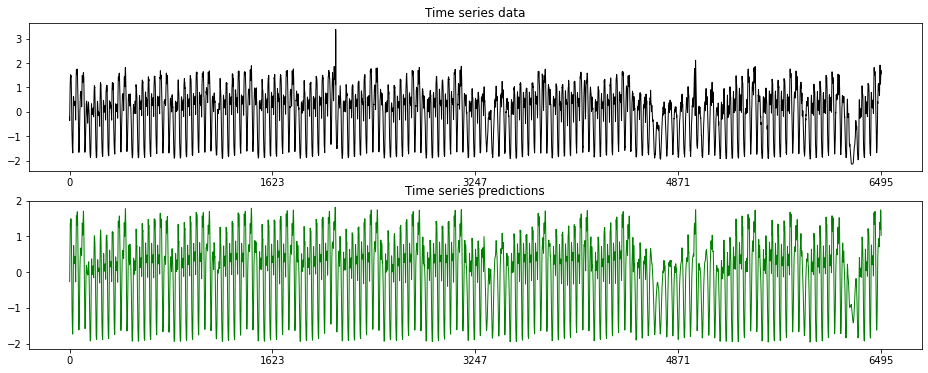

In [14]:
predictions = model.predict_time_series(data[validation_slices[0]], data_test)
vw.plot_time_series_forecast(data_test, predictions, on_same_plot=True)
vw.plot_time_series_forecast(data_test, predictions, on_same_plot=False)

# Anomalies predictions as red dots

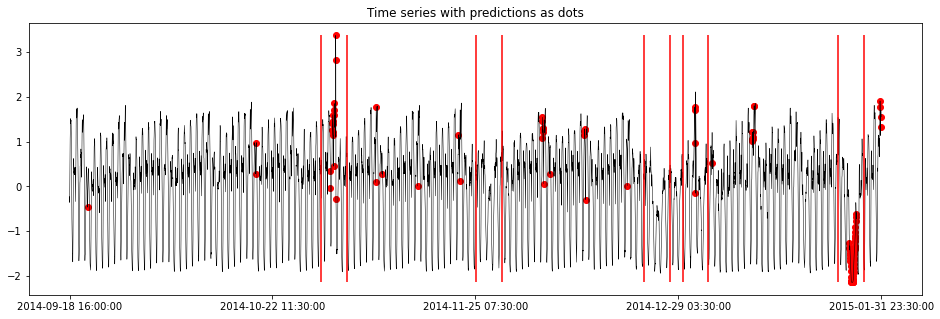

In [15]:
bars = vw.get_bars_indices_on_test_df(all_df,
                                      dataframe,
                                      PURE_DATA_KEY,
                                      GROUND_WINDOWS_PATH)
vw.plot_time_series_with_predicitons_bars(dataframe,
                                          labels,
                                          bars,
                                          pred_color='r')